<a href="https://colab.research.google.com/github/rubyvanrooyen/observation_planning/blob/main/comet67P/67P_katpoint_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install katpoint

     |████████████████████████████████| 99 kB 3.7 MB/s 


In [2]:
!pip install git+https://github.com/ska-sa/astrokat.git

  Cloning https://github.com/ska-sa/astrokat.git to /tmp/pip-req-build-a1_pfgcb
  Running command git clone -q https://github.com/ska-sa/astrokat.git /tmp/pip-req-build-a1_pfgcb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for astrokat: filename=astrokat-0.1.dev856+master.7dd7c9e-py3-none-any.whl size=61363 sha256=d565e5a194aace2c39a98ea5adda02f1003553006591d3814265f3aaa5bae1d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-mby4gpw1/wheels/48/68/38/460259a8276bb666804bc42ac8074a069b535a1a1cccda1237
  Created wheel for pyephem: filename=pyephem-9.99-py3-none-any.whl size=1568 sha256=f35a6966695004c0d8086dc4a90145e49aee009edbff3f55df4a47309593a524
  Stored in directory: /root/.cache/pip/wheels/30/12/37/6d3c470a337d412e8ac33b581cb2d67c825eaf063db830d74c
Successfully built astrokat pyephem


In [3]:
import ephem, katpoint

In [4]:
creation_time = '2021-09-23 23:00'

ref_antenna = katpoint.Antenna("ref, -30:42:39.8, 21:26:38.0, 1035.0, 0.0, , , 1.15")
ref_antenna.observer.horizon = ephem.degrees(str(15))
ref_antenna.observer.date = ephem.Date(creation_time)

print(ref_antenna.observer)

<ephem.Observer date='2021/9/23 23:00:00' epoch='2000/1/1 12:00:00' lon='21:26:38.0' lat='-30:42:39.8' elevation=1035.0m horizon=15:00:00.0 temp=15.0C pressure=0.0mBar>


Calibrators are identified using the transit pointing calculation notebook

In [5]:
sources = [           
#           'J0108+0134, radec gaincal, 1:08:38.77, 1:35:00.3',
           'J0431+2037, radec gaincal, 4:31:03.76, 20:37:34.3',
           'J0408-6545 | 0408-658, radec fluxcal bpcal delaycal, 04:08:20.3782, -65:45:09.080',
#           'J0318+1628, radec gaincal, 3:18:57.80, 16:28:32.7',
#           'J0059+0006 | 0056-001, radec gaincal, 00:59:5.5149, +00:06:51.621',
#           '3c39, radec target, 01:21:00.048, 03:44:20.72',
          ]
# From MPEC 2021-N06
xephem_comet67P = '67P/Churyumov-Gerasimenko,e,3.8713,36.3348,22.1246,3.457120,0.1533319,0.649811,341.5921,07/05.0/2021,2000,g 11.0,4.0'
comet_def = xephem_comet67P.replace(',', '~')
comet_str = f"67P/Churyumov-Gerasimenko, xephem, {comet_def}"
sources.append(comet_str)

obsfile = 'comet67P_observe.csv'
with open(obsfile, 'w') as fout:
    for line in sources:
        print(line)
        fout.write(line+"\n")

J0431+2037, radec gaincal, 4:31:03.76, 20:37:34.3
J0408-6545 | 0408-658, radec fluxcal bpcal delaycal, 04:08:20.3782, -65:45:09.080
67P/Churyumov-Gerasimenko, xephem, 67P/Churyumov-Gerasimenko~e~3.8713~36.3348~22.1246~3.457120~0.1533319~0.649811~341.5921~07/05.0/2021~2000~g 11.0~4.0


In [6]:
with open(obsfile, 'r') as fin:
    catalogue = katpoint.Catalogue(fin)

In [7]:
catalogue

<katpoint.Catalogue targets=3 names=4 at 0x7ffa2a26b8d0>

In [8]:
sun = katpoint.Target("Sun, special")
sun.body.compute(ref_antenna.observer)

In [9]:
katpt_targets = catalogue.filter(['target', 'xephem'])

In [10]:
for cnt, target in enumerate(katpt_targets):
    target.body.compute(ref_antenna.observer)
    separation_angle = ephem.separation(sun.body, target.body)
    print(cnt, target, target.body.alt)    

0 67P/Churyumov-Gerasimenko, tags=xephem solarsys, no flux info 14:54:44.5


In [11]:
import numpy
from astrokat import datetime2timestamp, timestamp2datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from datetime import datetime, timedelta

# source elevation over time (24H) plot
def source_elevation(catalogue, ref_antenna):
    """Generate a plot of elevation over time for 24 hour period.
    For all sources in provided catalogue at a specific location
    Parameters
    ----------
    catalogue: katpoint.Catalogue
    ref_antenna: katpoint.Antenna
        A MeerKAT reference antenna
    Returns
    -------
        matplotlib figure handle
    """
    catalogue.antenna = ref_antenna
    horizon = numpy.degrees(ref_antenna.observer.horizon)
    # All times and timestamps assumed UTC, no special conversion to
    # accommodate SAST allowed to prevent confusion
    creation_date = catalogue.antenna.observer.date
    creation_timestamp = datetime2timestamp(creation_date.datetime())
    time_range = creation_timestamp + numpy.arange(0, 24.0 * 60.0 * 60.0, 360.0)
    timestamps = [timestamp2datetime(ts) for ts in time_range]

    fig = plt.figure(figsize=(15, 7), facecolor="white")
    ax = plt.subplot(111)
    plt.subplots_adjust(right=0.8)
    fontP = FontProperties()
    fontP.set_size("small")

    for cnt, target in enumerate(catalogue.targets):
        elev = []
        for idx, timestamp in enumerate(timestamps):
            catalogue.antenna.observer.date = ephem.Date(timestamp)
            target.body.compute(catalogue.antenna.observer)
            elev.append(numpy.degrees(target.body.alt))

        label = "{} ".format(target.name)
        if "radec" in target.tags:
            target.tags.remove("radec")
        if "target" in target.tags:
            target.tags.remove("target")
        label += ", ".join(target.tags)

        myplot, = plt.plot_date(timestamps,
                                elev,
                                fmt='.',
                                linewidth=0,
                                label=label)
    ax.axhspan(15, horizon, facecolor="k", alpha=0.1)
    plt.grid()
    plt.legend(loc='center left',
               bbox_to_anchor=(1, 0.5),
               prop={'size': 10},
               numpoints=1)
    plt.ylabel("Elevation (deg)")
    plt.ylim(15, 90)
    plt.yticks(fontsize=10)

    # fix tick positions for proper time axis display
    utc_hrs = [timestamps[0] + timedelta(hours=hr) for hr in range(0, 25, 1)]
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    ax.set_xlim(utc_hrs[0], utc_hrs[-1])
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(24),
                                                  interval=1))
    locs = ax.get_xticks()
    locs_labels = matplotlib.dates.num2date(locs)
    locator = matplotlib.ticker.FixedLocator(locs)
    ax.xaxis.set_major_locator(locator)
    utc_timestamps = [locs_lbl.strftime("%H:%M") for locs_lbl in locs_labels]

    lst_timestamps = []
    for locs_ts in locs_labels:
        catalogue.antenna.observer.date = ephem.Date(locs_ts)
        lst_time = "{}".format(catalogue.antenna.observer.sidereal_time())
        lst_time_str = datetime.strptime(lst_time,
                                         "%H:%M:%S.%f").strftime("%H:%M")
        lst_timestamps.append(lst_time_str)

    ax.set_xticklabels(lst_timestamps,
                       rotation=30,
                       fontsize=10)
    ax.set_xlabel("Local Sidereal Time")

    ax2 = ax.twiny()
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(ax.get_xticks())
    ax2.xaxis.set_major_locator(locator)
    ax2.set_xticklabels(utc_timestamps,
                        rotation=30,
                        fontsize=10)
    ax2.set_xlabel('Time (UTC) starting from {}'.format(datetime.utcfromtimestamp(
        creation_timestamp).strftime('%Y-%m-%d %H:%M:%S')))

    return fig

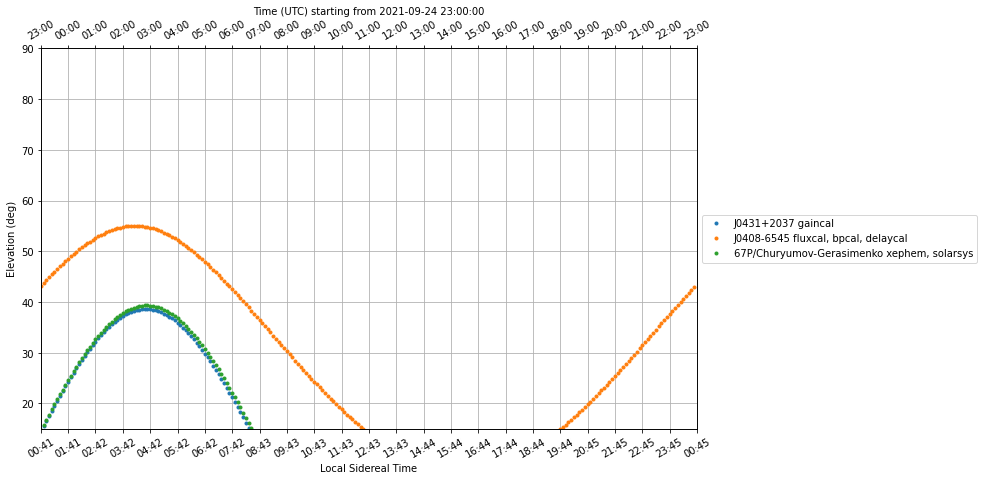

In [13]:
source_elevation(catalogue, ref_antenna)
plt.savefig('elevation.png')
plt.show()

```
configure_obs()
```
```
obs.sb.new(owner="ruby")
obs.sb.type=katuilib.ScheduleBlockTypes.OBSERVATION
obs.sb.description="Cometary OH: 67P narrow band line filler observation"
obs.sb.antenna_spec="available"
obs.sb.controlled_resources_spec="cbf,sdp"
obs.sb.instruction_set="run-obs-script /home/kat/katsdpscripts/observation/image.py /home/kat/katsdpcatalogues/comet67P_observe.csv -t 900 -g 90 -b 300 -i 3600 -m 5400"
obs.sb.proposal_id="SSV-20210701-SA-01"
obs.sb.horizon=15.0
obs.sb.desired_start_time= '2021-09-23 23:00'
obs.sb.to_defined()
obs.sb.to_approved()
obs.sb.unload()
```